In [ ]:
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.sql.functions import when, col

from pyspark.sql import functions as F
from pyspark.sql.types import StringType
import random

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Spark session
spark = SparkSession.builder.appName("DataLoadingExample").getOrCreate()

file_path = "/content/drive/Shareddrives/DDAM/Datasets aggiornati/df_filled.csv"
df = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)

# DATA PREPARING

In [ ]:
# Mocodes has too much distinct elements inside, this is a function that selects a random codes when the 'number of codes' > 1
def get_random_code(mocodes):
    codes = mocodes.split(" ")
    return random.choice(codes) if len(codes) > 1 else codes[0]
get_random_code_udf = F.udf(get_random_code, StringType())

df = df.withColumn("Mocodes", get_random_code_udf(F.col("Mocodes")))

In [ ]:
# Categorical columns to trasform with StringIndexer
categorical_cols = [
    'AREA NAME', 'Mocodes', 'Vict Descent','Crm Cd Desc', 'Vict Sex',
    'Premis Desc', 'Weapon Desc', 'Status Desc',
    'time_of_day', 'season'
]
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col} Index", handleInvalid="keep")
    for col in categorical_cols
]

pipeline = Pipeline(stages=indexers)

df_transformed = pipeline.fit(df).transform(df)
df_transformed.show(5)

+---------+----------+----------+----+-----------+-----------+--------+--------------------+-------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+-------------------+-------+---------+-------------------+-----------+------+--------+--------+---------------+-------------+------------------+-----------------+--------------+-----------------+-----------------+-----------------+-----------------+------------+
|    DR_NO| Date Rptd|  DATE OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|         Crm Cd Desc|Mocodes|Vict Age|Vict Sex|        Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status|Status Desc|Crm Cd 3|Crm Cd 4|           LOCATION|    LAT|      LON|           TIME OCC|time_of_day|season|Crm Cd 1|Crm Cd 2|AREA NAME Index|Mocodes Index|Vict Descent Index|Crm Cd Desc Index|Vict Sex Index|Premis Desc Index|Weapon Desc Index|Status Desc Index|time_of_day Index|se

In [ ]:
# Vict Descent compared to VIct Descent Index to understand the distribution of the value
df_transformed.select("Vict Descent", "Vict Descent Index").groupBy("Vict Descent", "Vict Descent Index").count().show(truncate = False)

+------------------------------+------------------+------+
|Vict Descent                  |Vict Descent Index|count |
+------------------------------+------------------+------+
|Japanese                      |7.0               |2182  |
|Samoan                        |16.0              |92    |
|American Indian/Alaskan Native|9.0               |1468  |
|Pacific Islander              |11.0              |407   |
|Black                         |2.0               |198595|
|Other Asian                   |3.0               |31374 |
|Guamanian                     |14.0              |120   |
|Korean                        |4.0               |8431  |
|Laotian                       |15.0              |113   |
|Vietnamese                    |8.0               |1608  |
|Hispanic/Latin/Mexican        |0.0               |432435|
|Hawaiian                      |12.0              |330   |
|Chinese                       |6.0               |6361  |
|Asian Indian                  |10.0              |789  

NEURAL NETWORK SIMPLE WITH VICT DESCENT INDEX

In [ ]:
# Creating the train and test set scaled and converted to Numpy
feature_cols = [
    'AREA NAME Index', 'Mocodes Index', 'Crm Cd Desc Index', 'Vict Sex Index',
    'Premis Desc Index', 'Weapon Desc Index', 'Status Desc Index',
    'time_of_day Index', 'season Index', 'Part 1-2', 'Vict Age'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_with_features = assembler.transform(df_transformed)

train_df, test_df = df_with_features.randomSplit([0.8, 0.2], seed=42)

X_train = np.array(train_df.select("features").rdd.map(lambda x: x[0].toArray()).collect())
y_train = np.array(train_df.select("Vict Descent Index").rdd.map(lambda x: x[0]).collect())

X_test = np.array(test_df.select("features").rdd.map(lambda x: x[0].toArray()).collect())
y_test = np.array(test_df.select("Vict Descent Index").rdd.map(lambda x: x[0]).collect())

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.4400 - loss: 1.3595 - val_accuracy: 0.4476 - val_loss: 1.3144
Epoch 2/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - accuracy: 0.4521 - loss: 1.2724 - val_accuracy: 0.4521 - val_loss: 1.3105
Epoch 3/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - accuracy: 0.4581 - loss: 1.2649 - val_accuracy: 0.4527 - val_loss: 1.3077
Epoch 4/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.4569 - loss: 1.2654 - val_accuracy: 0.4527 - val_loss: 1.3083
Epoch 5/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.4600 - loss: 1.2620 - val_accuracy: 0.4554 - val_loss: 1.3051
Epoch 6/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.4621 - loss: 1.2595 - val_accuracy: 0.4513 - val_loss: 1.3087
Epoch 7/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.4611 - loss: 1.2612 - val_accuracy: 0.4570 - val_loss: 1.3049
Epoch 8/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.48      0.82      0.60     86604
         1.0       0.44      0.34      0.38     58362
         2.0       0.52      0.04      0.07     39603
         3.0       0.00      0.00      0.00      6214
         4.0       0.00      0.00      0.00      1673
         5.0       0.00      0.00      0.00      1351
         6.0       0.00      0.00      0.00      1304
         7.0       0.00      0.00      0.00       432
         8.0       0.00      0.00      0.00       331
         9.0       0.00      0.00      0.00       301
        10.0       0.00      0.00      0.00       165
        11.0       0.00      0.00      0.00        91
        12.0       0.00      0.00      0.00        75
        13.0       0.00      0.00      0.00        23
        14.0       0.00      0.00      0.00        30
        15.0       0.00      0.00      0.00        25
        16.0       0.00      0.00      0.00        13

    accuracy              

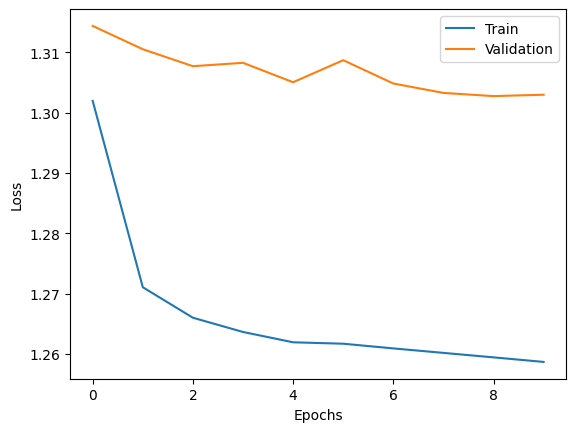

In [ ]:
# Classification on unbalaced data

def NN1():
    n_feature = X_train.shape[1]
    n_classes = len(np.unique(y_train))

    model = Sequential()
    model.add(Dense(256, input_dim=n_feature, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam", metrics=['accuracy'])
    return model


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = NN1()
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32,
                    callbacks=[early_stopping])

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred_classes))
print('Classification Report:')
print(classification_report(y_test, y_pred_classes))

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/10
24564/24564 ━━━━━━━━━━━━━━━━━━━━ 98s 4ms/step - accuracy: 0.4115 - loss: 4.1646 - val_accuracy: 0.0017 - val_loss: 2.6790
Epoch 2/10
24564/24564 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step - accuracy: 6.0303e-04 - loss: 2.9317 - val_accuracy: 0.0066 - val_loss: 2.7895
Epoch 3/10
24564/24564 ━━━━━━━━━━━━━━━━━━━━ 136s 3ms/step - accuracy: 0.0047 - loss: 2.8818 - val_accuracy: 8.3928e-04 - val_loss: 2.8140
Epoch 4/10
24564/24564 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - accuracy: 0.0029 - loss: 2.8354 - val_accuracy: 4.6288e-04 - val_loss: 2.8172
Epoch 5/10
24564/24564 ━━━━━━━━━━━━━━━━━━━━ 139s 3ms/step - accuracy: 0.0077 - loss: 2.8194 - val_accuracy: 3.8149e-04 - val_loss: 2.8108
Epoch 6/10
24564/24564 ━━━━━━━━━━━━━━━━━━━━ 139s 3ms/step - accuracy: 0.0043 - loss: 2.7810 - val_accuracy: 0.0017 - val_loss: 2.8277
Epoch 7/10
24564/24564 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - accuracy: 0.0064 - loss: 2.8475 - val_accuracy: 0.0022 - val_loss: 2.8369
Epoch 8/10
24564/24564 ━━━━━━━━━━━━━━━━━━━━ 139s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     86604
         1.0       0.00      0.00      0.00     58362
         2.0       0.00      0.00      0.00     39603
         3.0       0.00      0.00      0.00      6214
         4.0       0.00      0.00      0.00      1673
         5.0       0.00      0.00      0.00      1351
         6.0       0.00      0.00      0.00      1304
         7.0       0.00      1.00      0.00       432
         8.0       0.00      0.00      0.00       331
         9.0       0.00      0.00      0.00       301
        10.0       0.00      0.00      0.00       165
        11.0       0.00      0.00      0.00        91
        12.0       0.00      0.00      0.00        75
        13.0       0.00      0.00      0.00        23
        14.0       0.00      0.00      0.00        30
        15.0       0.00      0.00      0.00        25
        16.0       0.00      0.00      0.00        13

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


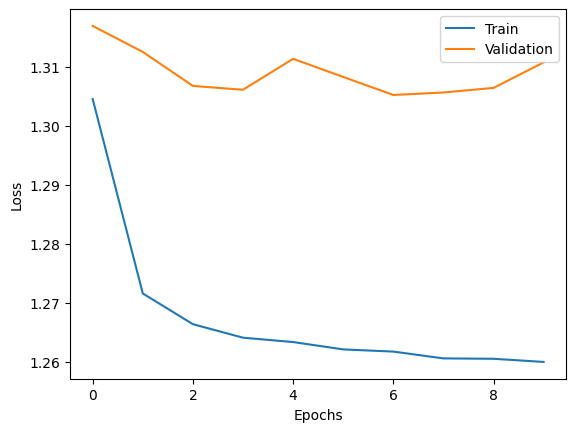

In [ ]:
# Classification on class weighted data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

hystory = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, class_weight=class_weight_dict)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred_classes))
print('Classification Report:')
print(classification_report(y_test, y_pred_classes))

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NN ON GROUPED CLASS TARGET


In [ ]:
# Grouping data in order to have only 4 classes
df_transformed = df_transformed.withColumn(
    "Descent Cluster",
    when(col("Vict Descent").isin(
        "Japanese", "Samoan", "American Indian/Alaskan Native", "Pacific Islander",
        "Other Asian", "Guamanian", "Korean", "Laotian", "Vietnamese", "Hawaiian",
        "Chinese", "Asian Indian", "Filipino", "Cambodian"), "Asian")
    .when(col("Vict Descent") == "Black", "Black")
    .when(col("Vict Descent") == "Hispanic/Latin/Mexican", "Sud American")
    .when(col("Vict Descent") == "White", "White")
    .otherwise("Unknown")
)

In [ ]:
# Creation of Descent Cluster Index, always with StringIndexer
cluster_indexer = StringIndexer(inputCol="Descent Cluster", outputCol="Descent Cluster Index")

df_transformed = cluster_indexer.fit(df_transformed).transform(df_transformed)

df_transformed.select("Descent Cluster", "Descent Cluster Index").show()

+---------------+---------------------+
|Descent Cluster|Descent Cluster Index|
+---------------+---------------------+
|   Sud American|                  0.0|
|          White|                  1.0|
|   Sud American|                  0.0|
|   Sud American|                  0.0|
|          White|                  1.0|
|   Sud American|                  0.0|
|   Sud American|                  0.0|
|   Sud American|                  0.0|
|   Sud American|                  0.0|
|   Sud American|                  0.0|
|   Sud American|                  0.0|
|          White|                  1.0|
|          White|                  1.0|
|          White|                  1.0|
|          White|                  1.0|
|          Black|                  2.0|
|          White|                  1.0|
|          White|                  1.0|
|   Sud American|                  0.0|
|   Sud American|                  0.0|
+---------------+---------------------+
only showing top 20 rows



In [ ]:
# Classes are now "more balanced"
df_transformed.groupBy("Descent Cluster").count().show()

+---------------+------+
|Descent Cluster| count|
+---------------+------+
|   Sud American|432435|
|          White|291445|
|          Black|198595|
|          Asian| 60163|
+---------------+------+



In [ ]:
# Creating the splitting data for the 4-class classification
feature_cols = [
    'AREA NAME Index', 'Mocodes Index', 'Crm Cd Desc Index', 'Vict Sex Index',
    'Premis Desc Index', 'Weapon Desc Index', 'Status Desc Index',
    'time_of_day Index', 'season Index', 'Part 1-2', 'Vict Age'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_with_features = assembler.transform(df_transformed)

train_df, test_df = df_with_features.randomSplit([0.8, 0.2], seed=42)

X_train = np.array(train_df.select("features").rdd.map(lambda x: x[0].toArray()).collect())
y_train = np.array(train_df.select("Descent Cluster Index").rdd.map(lambda x: x[0]).collect())

X_test = np.array(test_df.select("features").rdd.map(lambda x: x[0].toArray()).collect())
y_test = np.array(test_df.select("Descent Cluster Index").rdd.map(lambda x: x[0]).collect())

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Epoch 1/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - accuracy: 0.4455 - loss: 1.2173 - val_accuracy: 0.4481 - val_loss: 1.1951
Epoch 2/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.4548 - loss: 1.1768 - val_accuracy: 0.4509 - val_loss: 1.1926
Epoch 3/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.4565 - loss: 1.1766 - val_accuracy: 0.4484 - val_loss: 1.1945
Epoch 4/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 89s 5ms/step - accuracy: 0.4574 - loss: 1.1740 - val_accuracy: 0.4508 - val_loss: 1.1942
Epoch 5/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 126s 4ms/step - accuracy: 0.4603 - loss: 1.1720 - val_accuracy: 0.4506 - val_loss: 1.1939
Epoch 6/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.4610 - loss: 1.1721 - val_accuracy: 0.4526 - val_loss: 1.1896
Epoch 7/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step - accuracy: 0.4628 - loss: 1.1703 - val_accuracy: 0.4523 - val_loss: 1.1927
Epoch 8/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.47      0.82      0.60     86604
         1.0       0.44      0.33      0.38     58362
         2.0       0.52      0.03      0.06     39603
         3.0       0.00      0.00      0.00     12028

    accuracy                           0.46    196597
   macro avg       0.36      0.29      0.26    196597
weighted avg       0.44      0.46      0.39    196597



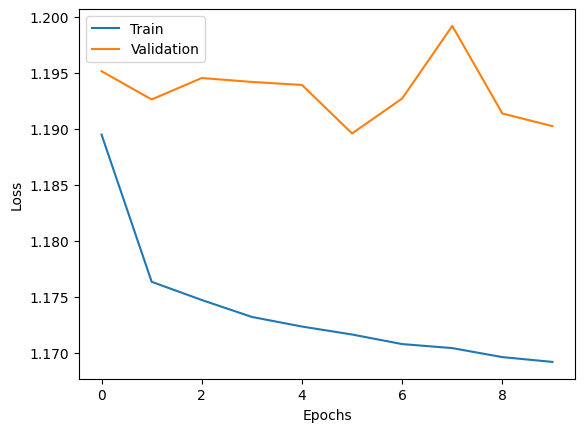

In [ ]:
# Applying the NN2 neural network
def NN2():
    n_feature = X_train.shape[1]
    n_classes = len(np.unique(y_train))

    model = Sequential([
        Input(shape=(n_feature,)),
        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam", metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = NN2()
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32,
                    callbacks=[early_stopping])

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred_classes))
print('Classification Report:')
print(classification_report(y_test, y_pred_classes))

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NEURAL NETWORK SUD AMERICAN VS ALL

In [ ]:
# Creating the column for binary classification and applying Stringindexer also on that new column
df_transformed = df_transformed.withColumn(
    "SAvsALL",
    when(col("Descent Cluster") == "Sud American", "Sud American").otherwise("Rest")
)

indexer = StringIndexer(inputCol="SAvsALL", outputCol="SAvsALL_Index")
df_transformed = indexer.fit(df_transformed).transform(df_transformed)

In [ ]:
#Splitting the data for the binary classification
feature_cols = [
    'AREA NAME Index', 'Mocodes Index', 'Crm Cd Desc Index', 'Vict Sex Index',
    'Premis Desc Index', 'Weapon Desc Index', 'Status Desc Index',
    'time_of_day Index', 'season Index', 'Part 1-2', 'Vict Age'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_with_features = assembler.transform(df_transformed)

train_df, test_df = df_with_features.randomSplit([0.8, 0.2], seed=42)

X_train = np.array(train_df.select("features").rdd.map(lambda x: x[0].toArray()).collect())
y_train = np.array(train_df.select("SAvsALL_Index").rdd.map(lambda x: x[0]).collect())

X_test = np.array(test_df.select("features").rdd.map(lambda x: x[0].toArray()).collect())
y_test = np.array(test_df.select("SAvsALL_Index").rdd.map(lambda x: x[0]).collect())

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Epoch 1/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.5949 - loss: 0.6938 - val_accuracy: 0.6016 - val_loss: 0.6703
Epoch 2/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.6044 - loss: 0.6691 - val_accuracy: 0.6056 - val_loss: 0.6681
Epoch 3/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.6063 - loss: 0.6676 - val_accuracy: 0.6060 - val_loss: 0.6680
Epoch 4/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.6062 - loss: 0.6673 - val_accuracy: 0.6038 - val_loss: 0.6682
Epoch 5/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.6082 - loss: 0.6663 - val_accuracy: 0.6060 - val_loss: 0.6667
Epoch 6/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.6088 - loss: 0.6657 - val_accuracy: 0.6059 - val_loss: 0.6677
Epoch 7/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.6088 - loss: 0.6658 - val_accuracy: 0.6079 - val_loss: 0.6661
Epoch 8/10
19651/19651 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 

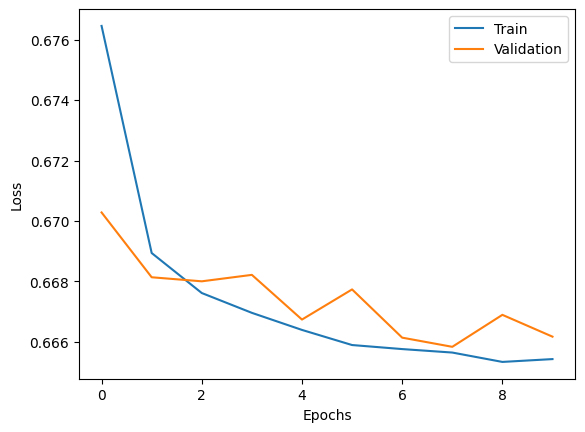

In [ ]:
def NN3():
    n_feature = X_train.shape[1]
    model = Sequential([
        Input(shape=(n_feature,)),
        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer="adam", metrics=['accuracy'])
    return model

y_train_bin = np.where(y_train == 0, 1, 0)  # 1 se Sud American, 0 altrimenti
y_test_bin = np.where(y_test == 0, 1, 0)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = NN3()
history = model.fit(X_train, y_train_bin, validation_split=0.2, epochs=10, batch_size=32,
                    callbacks=[early_stopping])

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Converte in 0 o 1 basato sulla probabilità

print('Accuracy %s' % accuracy_score(y_test_bin, y_pred_classes))
print('Classification Report:')
print(classification_report(y_test_bin, y_pred_classes))

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


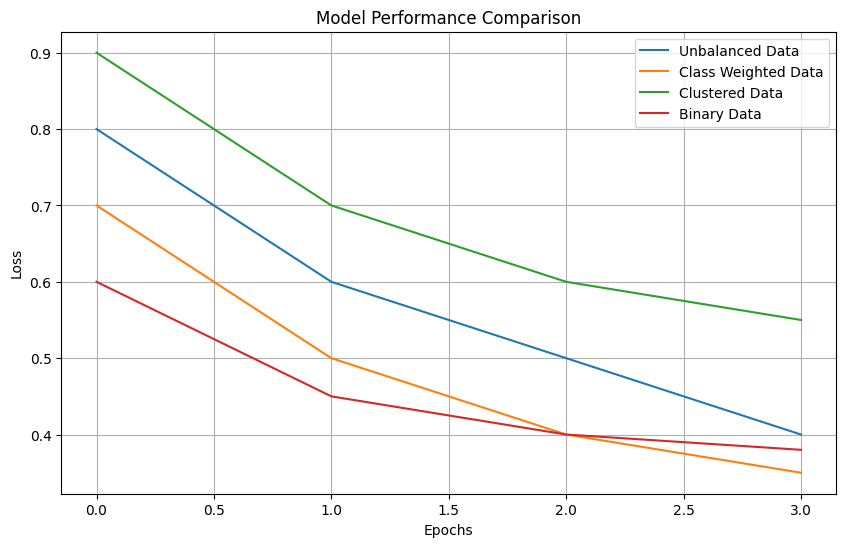

In [ ]:
history = type('obj', (object,), {'history': {'loss': [0.8, 0.6, 0.5, 0.4], 'val_loss': [0.7, 0.55, 0.5, 0.45]}})()
history_weighted = type('obj', (object,), {'history': {'loss': [0.7, 0.5, 0.4, 0.35], 'val_loss': [0.65, 0.5, 0.45, 0.4]}})()
history_clustered = type('obj', (object,), {'history': {'loss': [0.9, 0.7, 0.6, 0.55], 'val_loss': [0.85, 0.7, 0.6, 0.52]}})()
history_binary = type('obj', (object,), {'history': {'loss': [0.6, 0.45, 0.4, 0.38], 'val_loss': [0.55, 0.42, 0.4, 0.37]}})()


plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Unbalanced Data')

plt.plot(history_weighted.history['loss'], label='Class Weighted Data')

plt.plot(history_clustered.history['loss'], label='Clustered Data')

plt.plot(history_binary.history['loss'], label='Binary Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()